In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
%pip install  kneed

Note: you may need to restart the kernel to use updated packages.


In [3]:
data = pd.read_csv("marketing_campaign.csv", sep = '\t')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [5]:
data.head()

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  

[5 rows x 29 columns]

In [6]:
data.isnull().sum()
# here instead of removing those 24 rows, we can just fill them with the average of income

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [7]:
data = data.fillna(data['Income'].mean())

In [8]:
data['Education'].unique(), data['Marital_Status'].unique()

(array(['Graduation', 'PhD', 'Master', 'Basic', '2n Cycle'], dtype=object),
 array(['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone',
        'Absurd', 'YOLO'], dtype=object))

# Feature engineering

In [9]:
# age can be determined
# education can be encoded
# married column can be generated (together, married)
# family size can be created-  children_no + (if married: 2, else: 1)
# child column (kid + teen)
# total spendings

In [10]:
data['age'] = datetime.now().year - data['Year_Birth']
data['couple'] = data['Marital_Status'].map(lambda x: 1 if x in ['Together', 'Married'] else 0)

data['children'] = data['Kidhome'] + data['Teenhome']
data['total_family_size'] = data['children'] + data['Marital_Status'].map(lambda x: 2 if x in ['Together', 'Married'] else 1)
data['total_spending'] = data['MntWines'] + data['MntFruits'] + data['MntMeatProducts'] + data['MntFishProducts'] + data['MntSweetProducts'] + data['MntGoldProds']

In [11]:
data_filt = data.drop(['ID', 'Year_Birth', 'Marital_Status', 'Teenhome', 'Z_CostContact', 'Z_Revenue'], axis = 1)

In [12]:
data_filt['Dt_Customer'] = data_filt['Dt_Customer'].apply(lambda x: datetime.strptime(x, "%d-%m-%Y"))

In [13]:
data_filt

Education   Income  Kidhome Dt_Customer  Recency  MntWines  MntFruits  \
0     Graduation  58138.0        0  2012-09-04       58       635         88   
1     Graduation  46344.0        1  2014-03-08       38        11          1   
2     Graduation  71613.0        0  2013-08-21       26       426         49   
3     Graduation  26646.0        1  2014-02-10       26        11          4   
4            PhD  58293.0        1  2014-01-19       94       173         43   
...          ...      ...      ...         ...      ...       ...        ...   
2235  Graduation  61223.0        0  2013-06-13       46       709         43   
2236         PhD  64014.0        2  2014-06-10       56       406          0   
2237  Graduation  56981.0        0  2014-01-25       91       908         48   
2238      Master  69245.0        0  2014-01-24        8       428         30   
2239         PhD  52869.0        1  2012-10-15       40        84          3   

      MntMeatProducts  MntFishProducts  MntSweetProducts  ...  AcceptedCmp5  \
0                 546              172                88  ...             0   
1                   6                2                 1  ...             0   
2                 127              111                21  ...             0   
3                  20               10                 3  ...             0   
4                 118               46                27  ...             0   
...               ...              ...               ...  ...           ...   
2235              182               42               118  ...             0   
2236               30                0                 0  ...             0   
2237              217               32                12  ...             0   
2238              214               80                30  ...             0   
2239               61                2                 1  ...             0   

      AcceptedCmp1  AcceptedCmp2  Complain  Response  age  couple  children  \
0                0             0         0         1   67       0         0   
1                0             0         0         0   70       0         2   
2                0             0         0         0   59       1         0   
3                0             0         0         0   40       1         1   
4                0             0         0         0   43       1         1   
...            ...           ...       ...       ...  ...     ...       ...   
2235             0             0         0         0   57       1         1   
2236             1             0         0         0   78       1         3   
2237             0             0         0         0   43       0         0   
2238             0             0         0         0   68       1         1   
2239             0             0         0         1   70       1         2   

      total_family_size  total_spending  
0                     1            1617  
1                     3              27  
2                     2             776  
3                     3              53  
4                     3             422  
...                 ...             ...  
2235                  3            1341  
2236                  5             444  
2237                  1            1241  
2238                  3             843  
2239                  4             172  

[2240 rows x 28 columns]

In [14]:
data_filt['enrolled_for'] = datetime.now() - data_filt['Dt_Customer']
data_filt['enrolled_for'] = data_filt['enrolled_for'].apply(lambda x: x.days)

In [15]:
data_filt.drop('Dt_Customer', axis = 1, inplace = True)

# Visualization

In [16]:
# We cannot plot each column

data_filt.columns

Index(['Education', 'Income', 'Kidhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response', 'age', 'couple', 'children',
       'total_family_size', 'total_spending', 'enrolled_for'],
      dtype='object')

In [17]:
# removing outliers using zscores

new_data = pd.concat([data_filt.loc[:,['Education', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5','AcceptedCmp1',
                                'AcceptedCmp2', 'Complain', 'Response']],
                      data_filt.drop(['AcceptedCmp3','AcceptedCmp4', 'AcceptedCmp5','AcceptedCmp1','AcceptedCmp2',
                                       'Complain', 'Response'], axis = 1)
                      .select_dtypes('number')[zscore(data_filt.select_dtypes('number')) < 3]], axis = 1, join='inner').dropna()

In [18]:
# new_data['Response'].unique()
new_data

Education  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  \
0     Graduation             0             0             0             0   
1     Graduation             0             0             0             0   
2     Graduation             0             0             0             0   
3     Graduation             0             0             0             0   
4            PhD             0             0             0             0   
...          ...           ...           ...           ...           ...   
2234  Graduation             0             0             0             0   
2236         PhD             0             0             0             1   
2237  Graduation             0             1             0             0   
2238      Master             0             0             0             0   
2239         PhD             0             0             0             0   

      AcceptedCmp2  Complain  Response   Income  Kidhome  ...  \
0                0         0         1  58138.0        0  ...   
1                0         0         0  46344.0        1  ...   
2                0         0         0  71613.0        0  ...   
3                0         0         0  26646.0        1  ...   
4                0         0         0  58293.0        1  ...   
...            ...       ...       ...      ...      ...  ...   
2234             0         0         0  34421.0        1  ...   
2236             0         0         0  64014.0        2  ...   
2237             0         0         0  56981.0        0  ...   
2238             0         0         0  69245.0        0  ...   
2239             0         0         1  52869.0        1  ...   

      NumWebPurchases  NumCatalogPurchases  NumStorePurchases  \
0                 8.0                 10.0                  4   
1                 1.0                  1.0                  2   
2                 8.0                  2.0                 10   
3                 2.0                  0.0                  4   
4                 5.0                  3.0                  6   
...               ...                  ...                ...   
2234              1.0                  0.0                  2   
2236              8.0                  2.0                  5   
2237              2.0                  3.0                 13   
2238              6.0                  5.0                 10   
2239              3.0                  1.0                  4   

      NumWebVisitsMonth   age  couple  children  total_family_size  \
0                   7.0  67.0       0         0                  1   
1                   5.0  70.0       0         2                  3   
2                   4.0  59.0       1         0                  2   
3                   6.0  40.0       1         1                  3   
4                   5.0  43.0       1         1                  3   
...                 ...   ...     ...       ...                ...   
2234                7.0  50.0       1         1                  3   
2236                7.0  78.0       1         3                  5   
2237                6.0  43.0       0         0                  1   
2238                3.0  68.0       1         1                  3   
2239                7.0  70.0       1         2                  4   

      total_spending  enrolled_for  
0             1617.0          4380  
1               27.0          3830  
2              776.0          4029  
3               53.0          3856  
4              422.0          3878  
...              ...           ...  
2234            30.0          4080  
2236           444.0          3736  
2237          1241.0          3872  
2238           843.0          3873  
2239           172.0          4339  

[1978 rows x 28 columns]

d:\anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


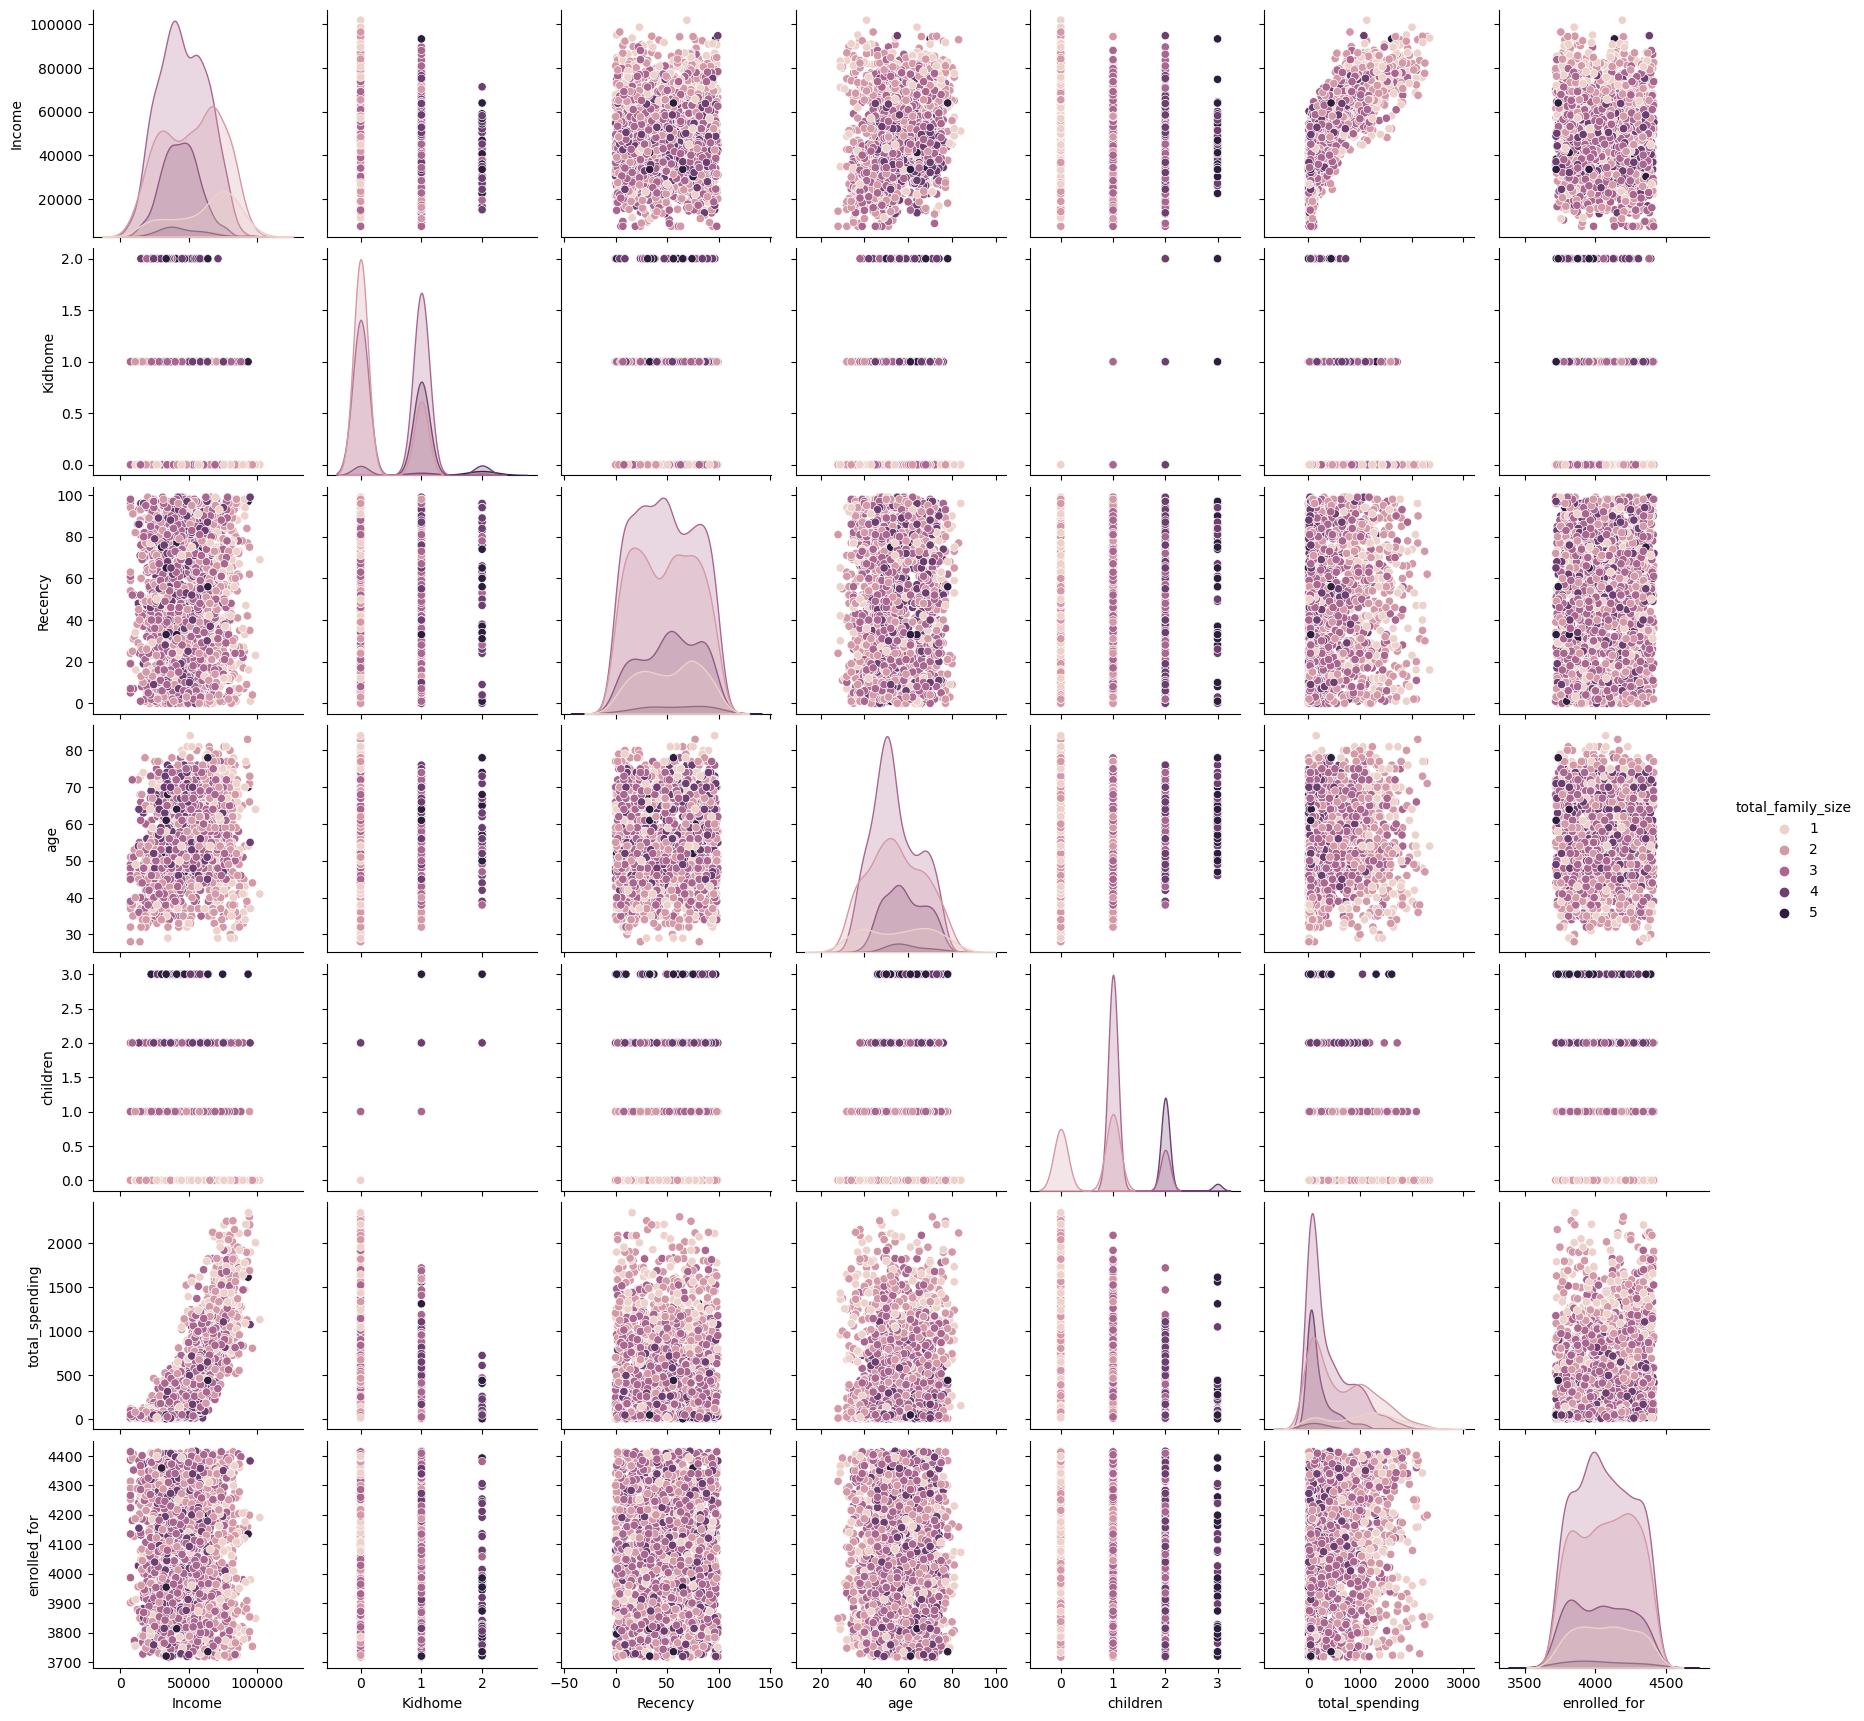

In [19]:
sns.pairplot(data = new_data.loc[:, ['Education', 'Income', 'Kidhome', 'Recency','age', 'children',
       'total_family_size', 'total_spending', 'enrolled_for']], hue = 'total_family_size')

Observations:
1. Higher the income, more is the spending
2. We are seeing less less purchase when customers have kids, that may be because the store deos not have stuffs kids would need
3. For smaller family size, spending is more
4. Majority of customers are between 35 to 70

# Pre-processing

In [20]:
proc_data = new_data.drop(['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5','AcceptedCmp1',
                                'AcceptedCmp2'], axis = 1)
# these aren't that useful

In [21]:
proc_data

Education  Complain  Response   Income  Kidhome  Recency  MntWines  \
0     Graduation         0         1  58138.0        0       58     635.0   
1     Graduation         0         0  46344.0        1       38      11.0   
2     Graduation         0         0  71613.0        0       26     426.0   
3     Graduation         0         0  26646.0        1       26      11.0   
4            PhD         0         0  58293.0        1       94     173.0   
...          ...       ...       ...      ...      ...      ...       ...   
2234  Graduation         0         0  34421.0        1       81       3.0   
2236         PhD         0         0  64014.0        2       56     406.0   
2237  Graduation         0         0  56981.0        0       91     908.0   
2238      Master         0         0  69245.0        0        8     428.0   
2239         PhD         0         1  52869.0        1       40      84.0   

      MntFruits  MntMeatProducts  MntFishProducts  ...  NumWebPurchases  \
0          88.0            546.0            172.0  ...              8.0   
1           1.0              6.0              2.0  ...              1.0   
2          49.0            127.0            111.0  ...              8.0   
3           4.0             20.0             10.0  ...              2.0   
4          43.0            118.0             46.0  ...              5.0   
...         ...              ...              ...  ...              ...   
2234        3.0              7.0              6.0  ...              1.0   
2236        0.0             30.0              0.0  ...              8.0   
2237       48.0            217.0             32.0  ...              2.0   
2238       30.0            214.0             80.0  ...              6.0   
2239        3.0             61.0              2.0  ...              3.0   

      NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth   age  couple  \
0                    10.0                  4                7.0  67.0       0   
1                     1.0                  2                5.0  70.0       0   
2                     2.0                 10                4.0  59.0       1   
3                     0.0                  4                6.0  40.0       1   
4                     3.0                  6                5.0  43.0       1   
...                   ...                ...                ...   ...     ...   
2234                  0.0                  2                7.0  50.0       1   
2236                  2.0                  5                7.0  78.0       1   
2237                  3.0                 13                6.0  43.0       0   
2238                  5.0                 10                3.0  68.0       1   
2239                  1.0                  4                7.0  70.0       1   

      children  total_family_size  total_spending  enrolled_for  
0            0                  1          1617.0          4380  
1            2                  3            27.0          3830  
2            0                  2           776.0          4029  
3            1                  3            53.0          3856  
4            1                  3           422.0          3878  
...        ...                ...             ...           ...  
2234         1                  3            30.0          4080  
2236         3                  5           444.0          3736  
2237         0                  1          1241.0          3872  
2238         1                  3           843.0          3873  
2239         2                  4           172.0          4339  

[1978 rows x 23 columns]

<Axes: >

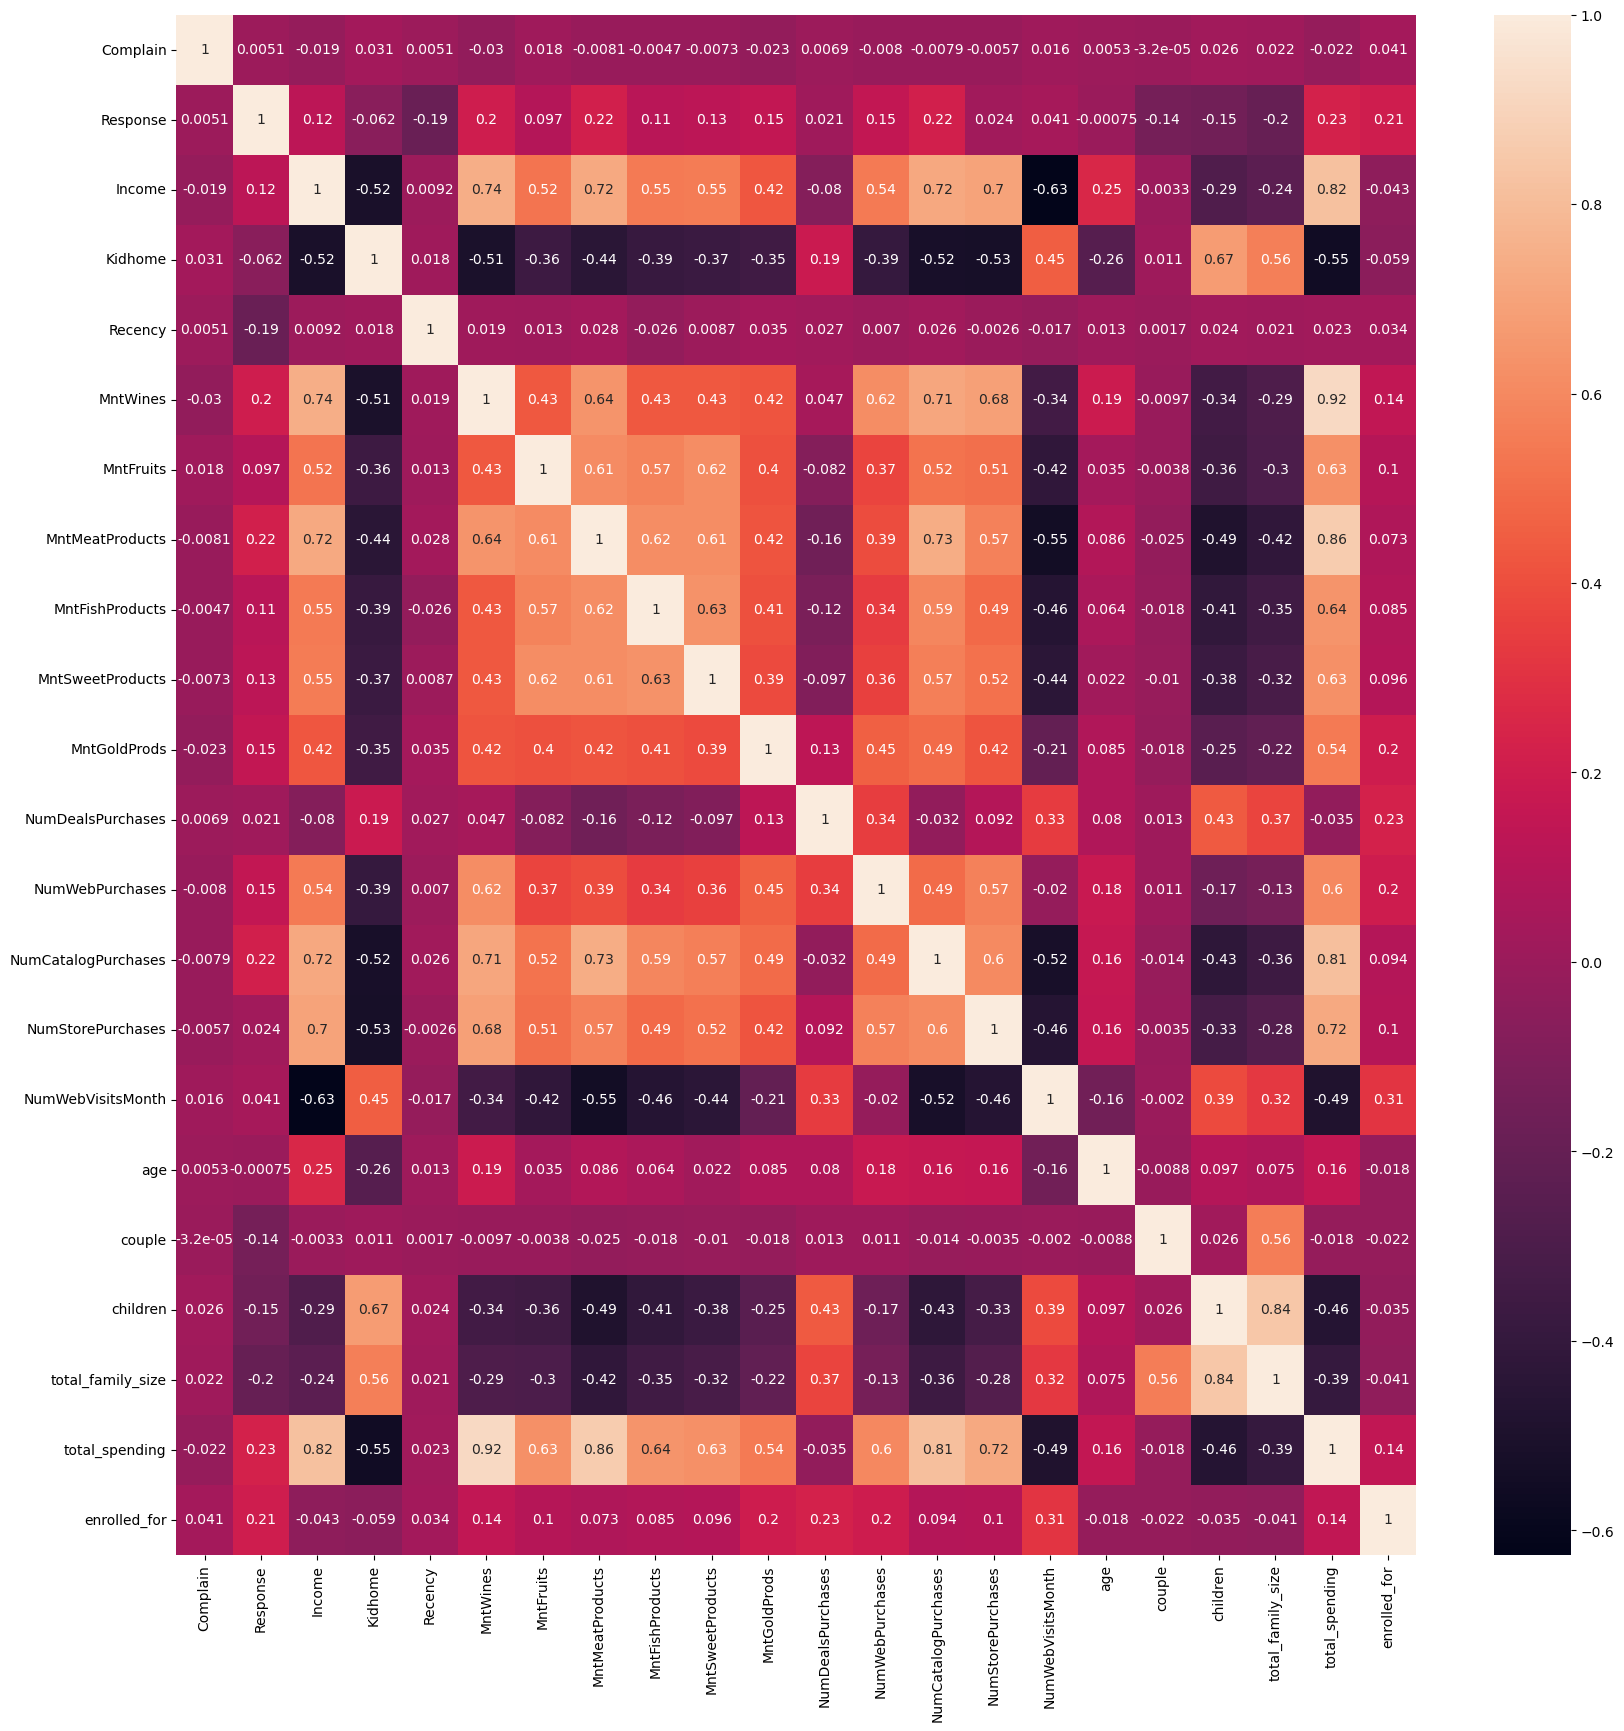

In [22]:
plt.rcParams['figure.figsize'] = (20,20)
sns.heatmap(proc_data.iloc[:,1:].corr(), annot = True)

In [23]:
encoder = LabelEncoder()
new_data['Education'] = encoder.fit_transform(new_data['Education'])

In [24]:
ss = StandardScaler()
scaled_new_data = new_data.copy()
scaled_new_data = ss.fit_transform(scaled_new_data)

In [25]:
scaled_new_data

array([[-0.37048003, -0.27386128, -0.27704797, ..., -1.87967447,
         2.05142553,  1.564664  ],
       [-0.37048003, -0.27386128, -0.27704797, ...,  0.38325681,
        -0.89667535, -1.1733709 ],
       [-0.37048003, -0.27386128, -0.27704797, ..., -0.74820883,
         0.49208412, -0.18270009],
       ...,
       [-0.37048003, -0.27386128,  3.60948318, ..., -1.87967447,
         1.35426457, -0.9642846 ],
       [ 0.51669854, -0.27386128, -0.27704797, ...,  0.38325681,
         0.61631227, -0.95930635],
       [ 1.40387712, -0.27386128, -0.27704797, ...,  1.51472245,
        -0.62782338,  1.36055594]])

Many of these features are weak and less contributing if we want to cluster the customers, so we need to perform PCA

In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca_data = pca.fit_transform(scaled_new_data)

In [27]:
from sklearn.cluster import KMeans, AgglomerativeClustering as ac

In [28]:
wcss = []
for k in range(1,15):
    km = KMeans(n_clusters = k, init = 'k-means++')
    km.fit(pca_data)
    wcss.append(km.inertia_)

d:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super

<Axes: >

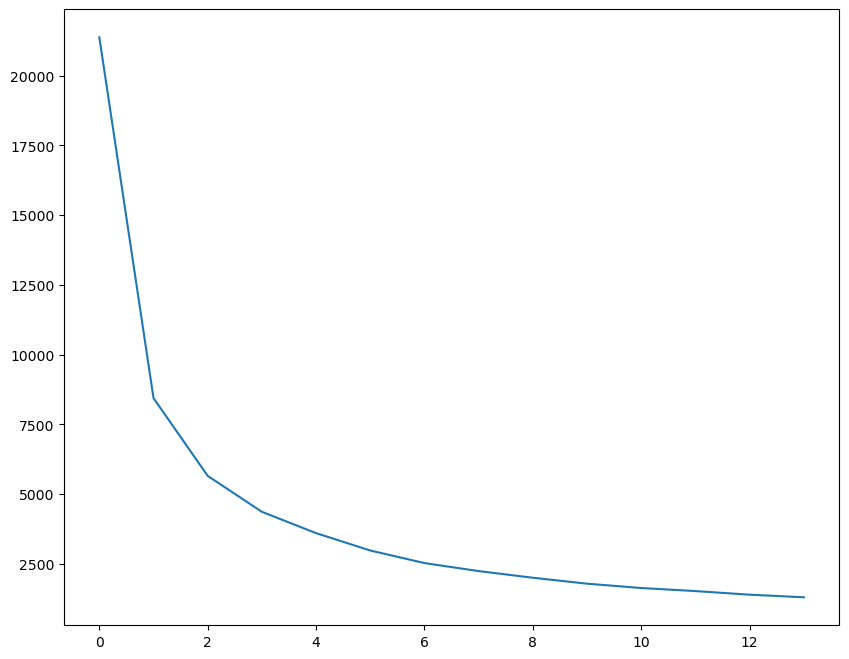

In [29]:
plt.rcParams['figure.figsize'] = (10, 8)
sns.lineplot(wcss)

In [30]:
from kneed import KneeLocator

In [31]:
KneeLocator(range(1, 15), wcss, curve = 'convex', direction = 'decreasing').elbow

3

In [32]:
cluster = ac(n_clusters = 3, linkage = 'ward', affinity = 'euclidean')
cluster.fit(pca_data)

d:\anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


AgglomerativeClustering(affinity='euclidean', n_clusters=3)

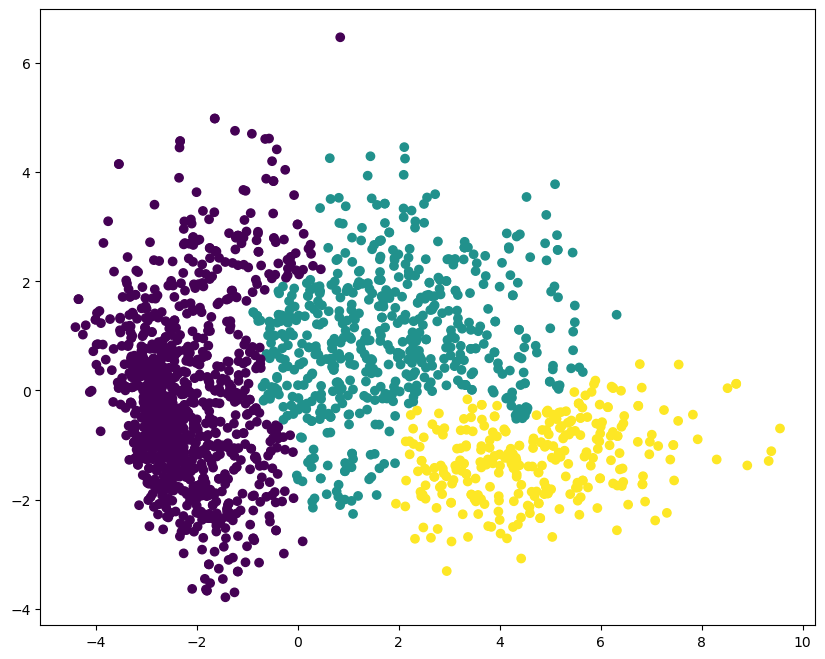

In [33]:
labels = cluster.labels_
plt.scatter(pca_data[:, 0], pca_data[:, 1], c = labels)

<Axes: ylabel='Count'>

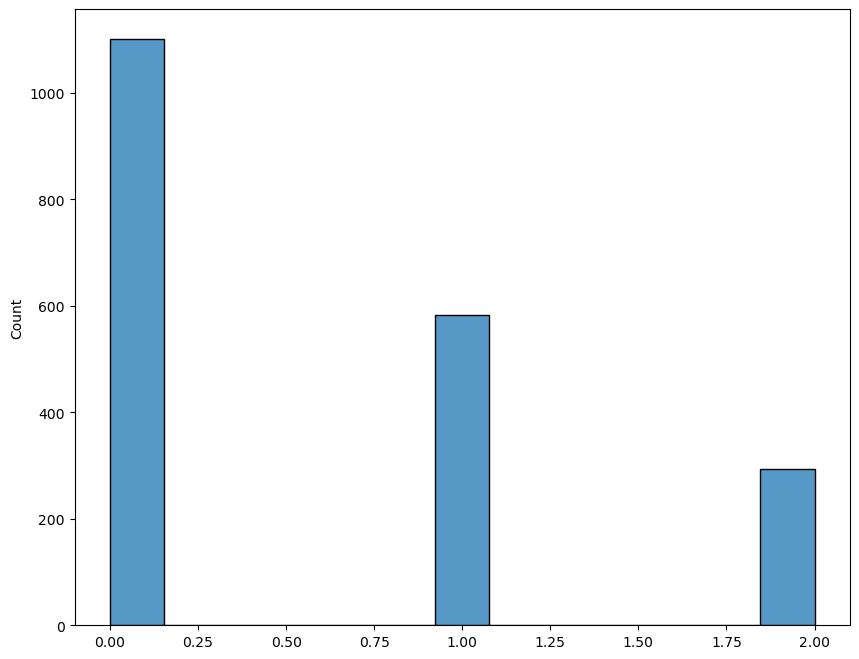

In [34]:
sns.histplot(x = labels)

In [35]:
proc_data['cluster'] = labels

In [36]:
proc_data

Education  Complain  Response   Income  Kidhome  Recency  MntWines  \
0     Graduation         0         1  58138.0        0       58     635.0   
1     Graduation         0         0  46344.0        1       38      11.0   
2     Graduation         0         0  71613.0        0       26     426.0   
3     Graduation         0         0  26646.0        1       26      11.0   
4            PhD         0         0  58293.0        1       94     173.0   
...          ...       ...       ...      ...      ...      ...       ...   
2234  Graduation         0         0  34421.0        1       81       3.0   
2236         PhD         0         0  64014.0        2       56     406.0   
2237  Graduation         0         0  56981.0        0       91     908.0   
2238      Master         0         0  69245.0        0        8     428.0   
2239         PhD         0         1  52869.0        1       40      84.0   

      MntFruits  MntMeatProducts  MntFishProducts  ...  NumCatalogPurchases  \
0          88.0            546.0            172.0  ...                 10.0   
1           1.0              6.0              2.0  ...                  1.0   
2          49.0            127.0            111.0  ...                  2.0   
3           4.0             20.0             10.0  ...                  0.0   
4          43.0            118.0             46.0  ...                  3.0   
...         ...              ...              ...  ...                  ...   
2234        3.0              7.0              6.0  ...                  0.0   
2236        0.0             30.0              0.0  ...                  2.0   
2237       48.0            217.0             32.0  ...                  3.0   
2238       30.0            214.0             80.0  ...                  5.0   
2239        3.0             61.0              2.0  ...                  1.0   

      NumStorePurchases  NumWebVisitsMonth   age  couple  children  \
0                     4                7.0  67.0       0         0   
1                     2                5.0  70.0       0         2   
2                    10                4.0  59.0       1         0   
3                     4                6.0  40.0       1         1   
4                     6                5.0  43.0       1         1   
...                 ...                ...   ...     ...       ...   
2234                  2                7.0  50.0       1         1   
2236                  5                7.0  78.0       1         3   
2237                 13                6.0  43.0       0         0   
2238                 10                3.0  68.0       1         1   
2239                  4                7.0  70.0       1         2   

      total_family_size  total_spending  enrolled_for  cluster  
0                     1          1617.0          4380        2  
1                     3            27.0          3830        0  
2                     2           776.0          4029        2  
3                     3            53.0          3856        0  
4                     3           422.0          3878        1  
...                 ...             ...           ...      ...  
2234                  3            30.0          4080        0  
2236                  5           444.0          3736        0  
2237                  1          1241.0          3872        2  
2238                  3           843.0          3873        1  
2239                  4           172.0          4339        0  

[1978 rows x 24 columns]

d:\anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


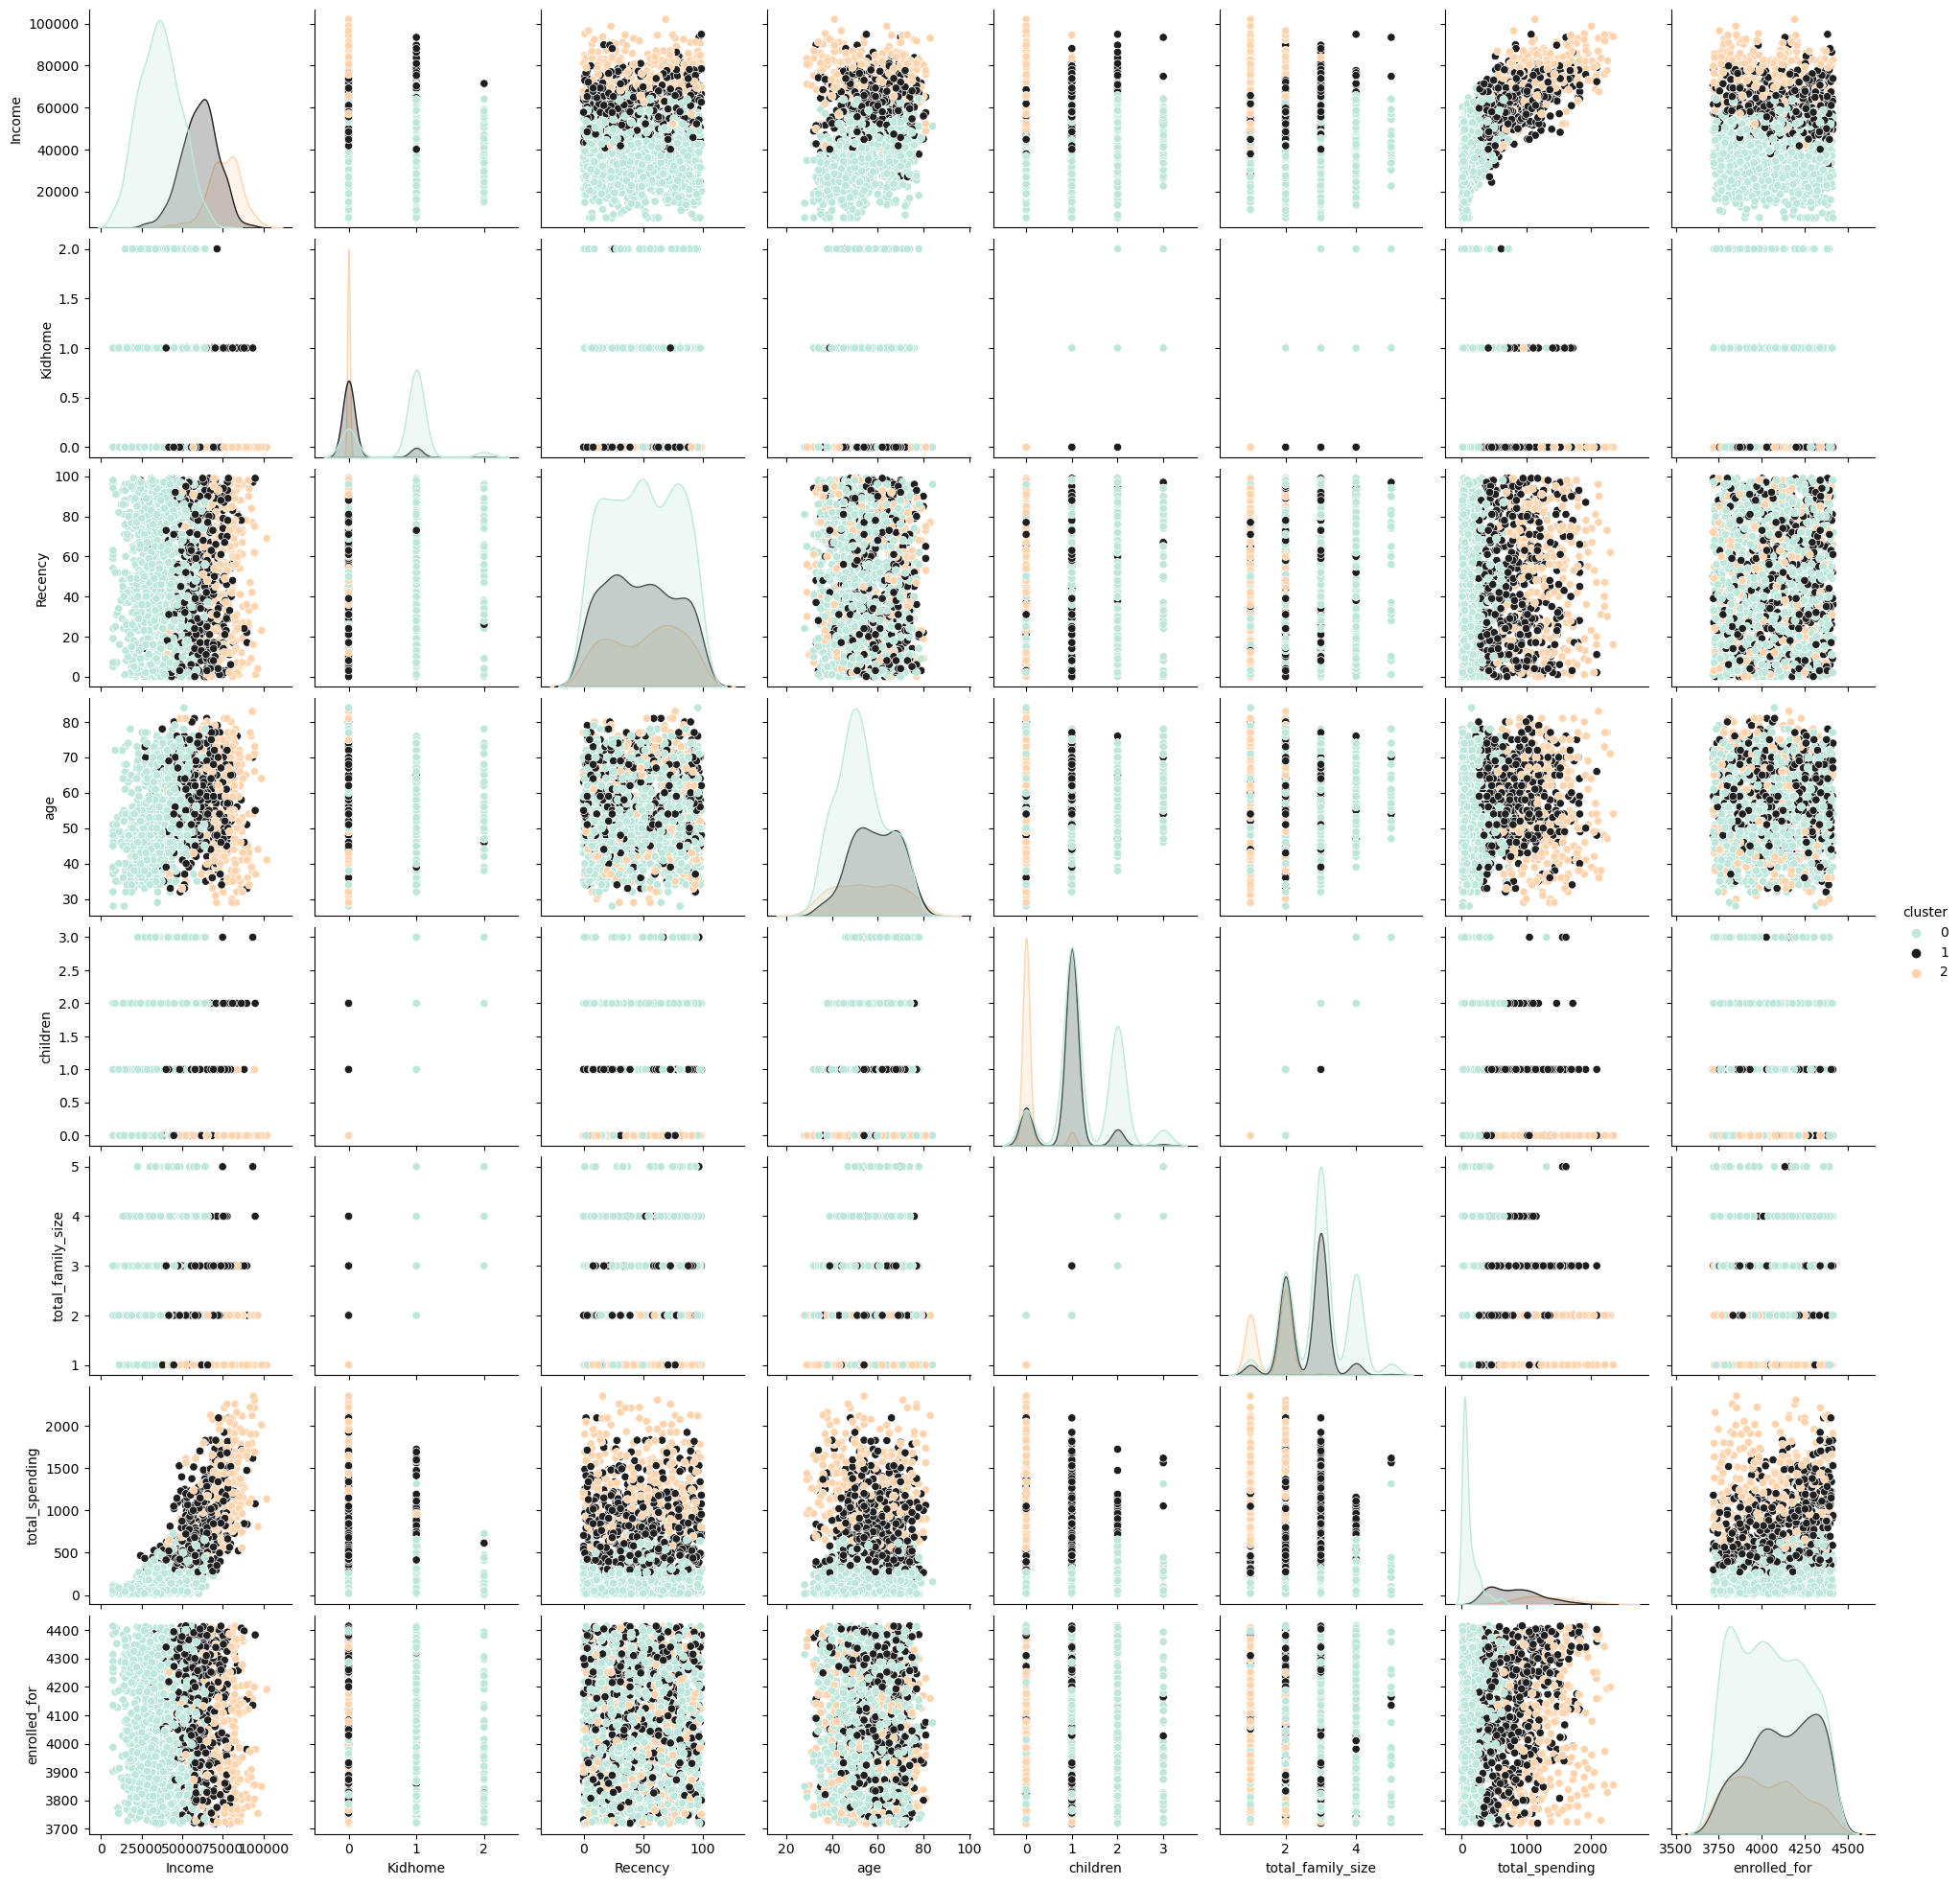

In [37]:
sns.pairplot(data = proc_data.loc[:, ['Education', 'Income', 'Kidhome', 'Recency','age', 'children',
       'total_family_size', 'total_spending', 'enrolled_for', 'cluster']], hue = 'cluster', palette = 'icefire')

1. spending: C1 < C2 < C3
2. C3 has less number of childs and thus posses a small family

In [38]:
proc_data.columns

Index(['Education', 'Complain', 'Response', 'Income', 'Kidhome', 'Recency',
       'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
       'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'age', 'couple', 'children', 'total_family_size',
       'total_spending', 'enrolled_for', 'cluster'],
      dtype='object')

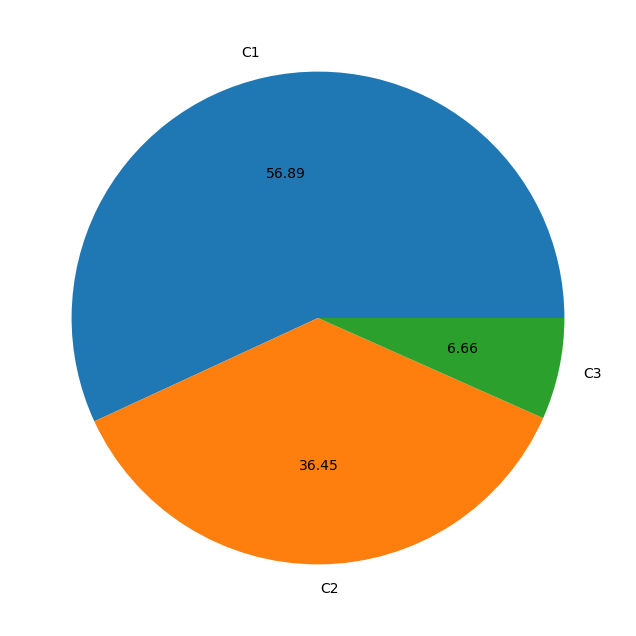

In [39]:
# Number of Deals Purchases by Category
plt.pie(proc_data.groupby('cluster').sum()['NumDealsPurchases'], labels = ['C1', 'C2', 'C3'], autopct = '%.2f')
plt.show()

In [40]:
proc_data

Education  Complain  Response   Income  Kidhome  Recency  MntWines  \
0     Graduation         0         1  58138.0        0       58     635.0   
1     Graduation         0         0  46344.0        1       38      11.0   
2     Graduation         0         0  71613.0        0       26     426.0   
3     Graduation         0         0  26646.0        1       26      11.0   
4            PhD         0         0  58293.0        1       94     173.0   
...          ...       ...       ...      ...      ...      ...       ...   
2234  Graduation         0         0  34421.0        1       81       3.0   
2236         PhD         0         0  64014.0        2       56     406.0   
2237  Graduation         0         0  56981.0        0       91     908.0   
2238      Master         0         0  69245.0        0        8     428.0   
2239         PhD         0         1  52869.0        1       40      84.0   

      MntFruits  MntMeatProducts  MntFishProducts  ...  NumCatalogPurchases  \
0          88.0            546.0            172.0  ...                 10.0   
1           1.0              6.0              2.0  ...                  1.0   
2          49.0            127.0            111.0  ...                  2.0   
3           4.0             20.0             10.0  ...                  0.0   
4          43.0            118.0             46.0  ...                  3.0   
...         ...              ...              ...  ...                  ...   
2234        3.0              7.0              6.0  ...                  0.0   
2236        0.0             30.0              0.0  ...                  2.0   
2237       48.0            217.0             32.0  ...                  3.0   
2238       30.0            214.0             80.0  ...                  5.0   
2239        3.0             61.0              2.0  ...                  1.0   

      NumStorePurchases  NumWebVisitsMonth   age  couple  children  \
0                     4                7.0  67.0       0         0   
1                     2                5.0  70.0       0         2   
2                    10                4.0  59.0       1         0   
3                     4                6.0  40.0       1         1   
4                     6                5.0  43.0       1         1   
...                 ...                ...   ...     ...       ...   
2234                  2                7.0  50.0       1         1   
2236                  5                7.0  78.0       1         3   
2237                 13                6.0  43.0       0         0   
2238                 10                3.0  68.0       1         1   
2239                  4                7.0  70.0       1         2   

      total_family_size  total_spending  enrolled_for  cluster  
0                     1          1617.0          4380        2  
1                     3            27.0          3830        0  
2                     2           776.0          4029        2  
3                     3            53.0          3856        0  
4                     3           422.0          3878        1  
...                 ...             ...           ...      ...  
2234                  3            30.0          4080        0  
2236                  5           444.0          3736        0  
2237                  1          1241.0          3872        2  
2238                  3           843.0          3873        1  
2239                  4           172.0          4339        0  

[1978 rows x 24 columns]

In [41]:
# sns.histplot(data = proc_data, x = 'Education', hue = 'cluster')
l = proc_data.loc[:, ['cluster', 'Education']]
l = pd.concat([l, pd.get_dummies(l['Education']).replace({True:1, False:0})], axis= 1).drop('Education', axis = 1)
l = l.groupby('cluster').sum()

In [42]:
l

2n Cycle  Basic  Graduation  Master  PhD
cluster                                          
0             112     52         541     187  210
1              35      1         290      96  160
2              26      0         140      54   74

<Axes: xlabel='Income', ylabel='Count'>

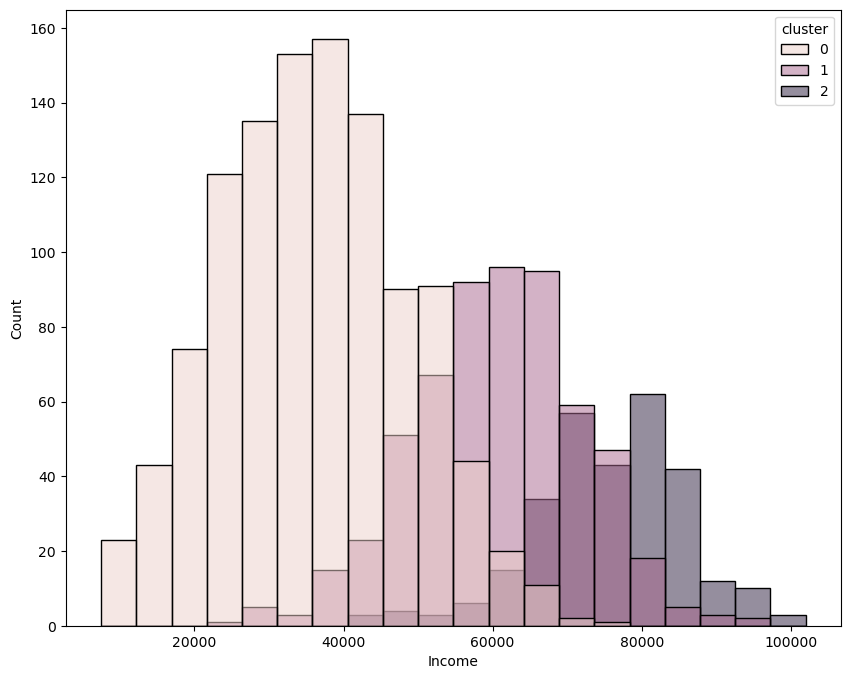

In [43]:
sns.histplot(data = proc_data, x = 'Income', hue = 'cluster')

<Axes: xlabel='age', ylabel='Count'>

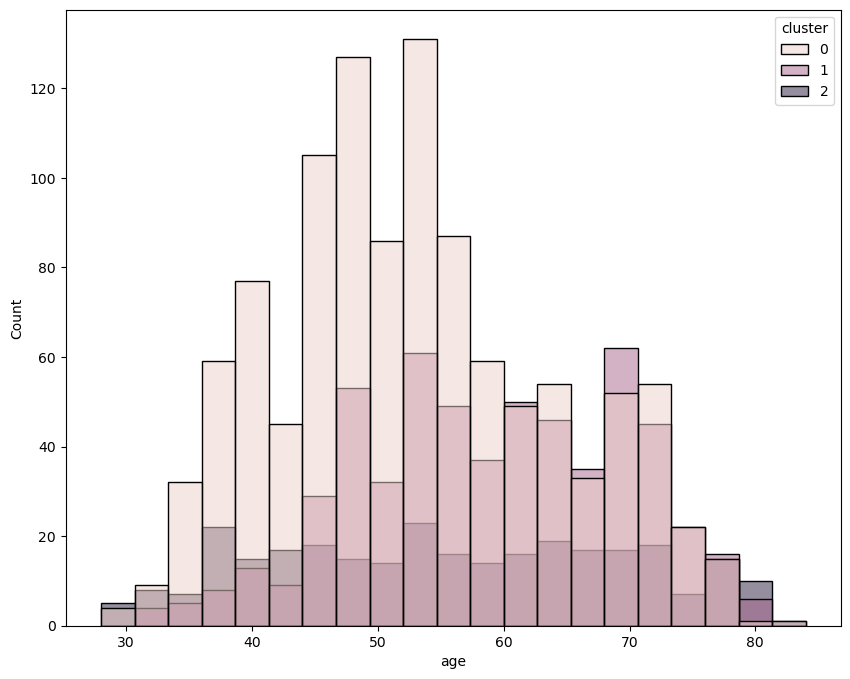

In [44]:
sns.histplot(data = proc_data, x = 'age', hue = 'cluster')

Cluster Profiles:

Cluster 1:
1. Spends less than 700
2. Income is under 60K
3. Has 0 to 2 kids (usually atleast 1 kid)
4. Family size is >= 2
5. Spends less
6. Buys at high frequency

Cluster 2:
1. Has income between 40k to 70k 
2. Buys at average frequency
3. Usually has no kids
4. Has average spending habits
5. Family size is between 1 to 4
6. At least 1 child

Cluster 3:
1. Usually spends more than other clusters
2. Income is high (80k to 100k)
3. Not a parent
4. spends the lowest of all
5. Family size is 1
6. Buys less frequent than cluster 2